In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import h5py

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

#---------------------------
#ordenacao de informacoes em backend: tensorflow ou theano
#representa o "image data format"
#ambos possuem as mesmas informacoes, mas os parametros sao passados em posicoes diferentes
#TF:(808L,128L,128L,3L) : (num_samples, num_rows, num_columns, num_channels)
#TH:(808L,3L,128L,128L) : (num_samples, num_channels, num_rows, num_columns)
from keras import backend as K
K.set_image_dim_ordering('th')

from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import SGD,RMSprop,adam

#%%
# Saving and loading model and weights
from keras.models import model_from_json
from keras.models import load_model

Using TensorFlow backend.


In [2]:
PATH = os.getcwd()

# Define data path
data_path = PATH + '/data'
data_dir_list = os.listdir(data_path)

img_rows=128
img_cols=128
num_channel=1 
num_epoch=10

img_data_list=[]

#---------------------------
#diretorio onde estao todas as imagens
for dataset in data_dir_list:
    img_list=os.listdir(data_path+'/'+ dataset)
    print ('Loaded the images of dataset-'+'{}'.format(dataset))
    for img in img_list:
        input_img=cv2.imread(data_path + '/'+ dataset + '/'+ img )
        input_img=cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
        input_img_resize=cv2.resize(input_img,(128,128))
        img_data_list.append(input_img_resize)
    #Imagens por classes
    print (len(img_data_list), " imgs\n")


img_data = np.array(img_data_list)
img_data = img_data.astype('float32')
img_data /= 255

#---------------------------
if num_channel==1:
    if K.image_dim_ordering()=='th':
        img_data= np.expand_dims(img_data, axis=1) 
        print (img_data.shape)
    else:
        img_data= np.expand_dims(img_data, axis=4) 
        print (img_data.shape)
#se for colorida a imagem
else:
    if K.image_dim_ordering()=='th':
        img_data=np.rollaxis(img_data,3,1)
        print (img_data.shape)

Loaded the images of dataset-Percurso1.1
206  imgs

Loaded the images of dataset-Percurso3.3
315  imgs

Loaded the images of dataset-Percurso3.2
451  imgs

Loaded the images of dataset-Percurso4.2
639  imgs

Loaded the images of dataset-Percurso1.2
825  imgs

Loaded the images of dataset-Percurso2.1
1055  imgs

Loaded the images of dataset-Percurso3.1
1183  imgs

Loaded the images of dataset-Percurso4.1
1349  imgs

Loaded the images of dataset-Percurso2.2
1548  imgs

Loaded the images of dataset-Percurso2.3
1751  imgs

Loaded the images of dataset-Percurso4.3
1977  imgs

Loaded the images of dataset-Percurso1.3
2247  imgs

(2247, 1, 128, 128)


In [3]:
#%%
USE_SKLEARN_PREPROCESSING=False

if USE_SKLEARN_PREPROCESSING:
    # using sklearn for preprocessing
    from sklearn import preprocessing

    def image_to_feature_vector(image, size=(128, 128)):
        # resize the image to a fixed size, then flatten the image into
        # a list of raw pixel intensities
        return cv2.resize(image, size).flatten()
    
    img_data_list=[]
    for dataset in data_dir_list:
        img_list=os.listdir(data_path+'/'+ dataset)
        print ('Loaded the images of dataset-'+'{}\n'.format(dataset))
        for img in img_list:
            input_img=cv2.imread(data_path + '/'+ dataset + '/'+ img )
            input_img=cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
            input_img_flatten=image_to_feature_vector(input_img,(128,128))
            img_data_list.append(input_img_flatten)

    img_data = np.array(img_data_list)
    img_data = img_data.astype('float32')
    print (img_data.shape)
    img_data_scaled = preprocessing.scale(img_data)
    print (img_data_scaled.shape)

    print (np.mean(img_data_scaled))
    print (np.std(img_data_scaled))

    print (img_data_scaled.mean(axis=0))
    print (img_data_scaled.std(axis=0))

    if K.image_dim_ordering()=='th':
        img_data_scaled=img_data_scaled.reshape(img_data.shape[0],num_channel,img_rows,img_cols)
        print (img_data_scaled.shape)

    else:
        img_data_scaled=img_data_scaled.reshape(img_data.shape[0],img_rows,img_cols,num_channel)
        print (img_data_scaled.shape)

    if K.image_dim_ordering()=='th':
        img_data_scaled=img_data_scaled.reshape(img_data.shape[0],num_channel,img_rows,img_cols)
        print (img_data_scaled.shape)

    else:
        img_data_scaled=img_data_scaled.reshape(img_data.shape[0],img_rows,img_cols,num_channel)
        print (img_data_scaled.shape)

if USE_SKLEARN_PREPROCESSING:
    img_data=img_data_scaled

In [4]:
# Define the number of classes
num_classes = 12

num_of_samples = img_data.shape[0]
labels = np.ones((num_of_samples,),dtype='int64')

#Quantidade de imagens por classes
labels[0:206]=0
labels[207:315]=1
labels[316:451]=2
labels[452:639]=3
labels[670:825]=4
labels[826:1055]=5
labels[1056:1183]=6
labels[1184:1349]=7
labels[1350:1548]=8
labels[1549:1751]=9
labels[1752:1977]=10
labels[1978:]=11
  
names = ['Percurso1.1','Percurso3.3','Percurso3.2','Percurso4.2',\
         'Percurso1.2','Percurso2.1','Percurso3.1','Percurso4.1',\
         'Percurso2.2','Percurso2.3','Percurso4.3','Percurso1.3']
  
# convert class labels to on-hot encoding
Y = np_utils.to_categorical(labels, num_classes)

#Shuffle the dataset
x,y = shuffle(img_data,Y, random_state=2)
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)

# Defining the model
input_shape=img_data[0].shape
print("Input_shape: " , input_shape)

model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same',input_shape=input_shape))
model.add(Activation('relu'))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('elu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('elu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(optimizer='adadelta',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()
model.get_config()
model.layers[0].get_config()
model.layers[0].input_shape
model.layers[0].output_shape
model.layers[0].get_weights()
np.shape(model.layers[0].get_weights()[0])
model.layers[0].trainable

Input_shape:  (1, 128, 128)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 128, 128)      320       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 128, 128)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 126, 126)      9248      
_________________________________________________________________
activation_2 (Activation)    (None, 32, 126, 126)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 63, 63)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 63, 63)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 61, 61) 

True

In [5]:
# Training
hist = model.fit(X_train, y_train, batch_size=50, epochs=num_epoch, verbose=1, validation_data=(X_test, y_test))

Train on 1797 samples, validate on 450 samples
Epoch 1/10
1797/1797 [==============================] - 507s 282ms/step - loss: 2.5244 - acc: 0.1558 - val_loss: 2.3633 - val_acc: 0.2378
Epoch 2/10
1797/1797 [==============================] - 485s 270ms/step - loss: 1.9148 - acc: 0.3528 - val_loss: 1.2606 - val_acc: 0.5822
Epoch 3/10
1797/1797 [==============================] - 499s 278ms/step - loss: 0.8939 - acc: 0.7212 - val_loss: 0.5594 - val_acc: 0.8378
Epoch 4/10
1797/1797 [==============================] - 466s 259ms/step - loss: 0.5397 - acc: 0.8325 - val_loss: 0.3294 - val_acc: 0.9022
Epoch 5/10
1797/1797 [==============================] - 452s 251ms/step - loss: 0.3735 - acc: 0.8848 - val_loss: 0.2975 - val_acc: 0.9156
Epoch 6/10
1797/1797 [==============================] - 453s 252ms/step - loss: 0.2709 - acc: 0.9110 - val_loss: 0.2465 - val_acc: 0.9289
Epoch 7/10
1797/1797 [==============================] - 448s 249ms/step - loss: 0.2475 - acc: 0.9199 - val_loss: 0.2487 - val

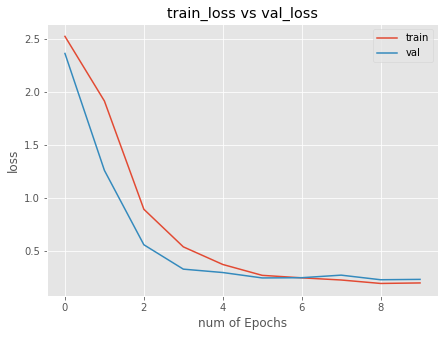

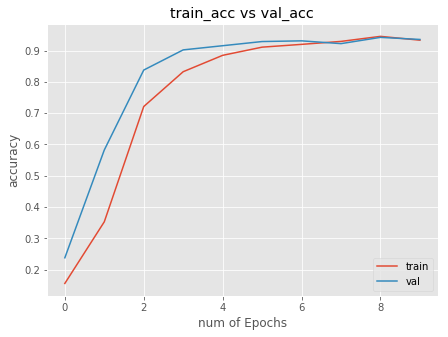

In [10]:
# visualizing losses and accuracy
train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['acc']
val_acc=hist.history['val_acc']
xc=range(num_epoch)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['ggplot'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['ggplot'])

In [11]:
# Evaluating the model
score = model.evaluate(X_test, y_test)
print('Test Loss:', score[0])
print('Test accuracy:', score[1])

#test_image = X_test[0:1]
#print (test_image.shape)

#print(model.predict(test_image))
#print(model.predict_classes(test_image))
#print(y_test[0:1])

450/450 [==============================] - 50s 111ms/step
Test Loss: 0.23290190294475502
Test accuracy: 0.9355555555555556


In [12]:
# Printing the confusion matrix
from sklearn.metrics import classification_report,confusion_matrix
import itertools

Y_pred = model.predict(X_test)
print(Y_pred)
y_pred = np.argmax(Y_pred, axis=1)
print(y_pred)
#y_pred = model.predict_classes(X_test)
#print(y_pred)
target_names = ['class 0(Percurso1.1)', 'class 1(Percurso3.3)', 'class 2(Percurso3.2)','class 3(Percurso4.2)',\
                'class 4(Percurso1.2)', 'class 5(Percurso2.1)', 'class 6(Percurso3.1)','class 7(Percurso4.1)',\
                'class 8(Percurso2.2)', 'class 9(Percurso2.3)', 'class 10(Percurso4.3)','class 11(Percurso1.3)']

print(classification_report(np.argmax(y_test,axis=1), y_pred,target_names=target_names))

print(confusion_matrix(np.argmax(y_test,axis=1), y_pred))

[[9.9957436e-01 1.3017238e-06 2.6541227e-07 ... 5.0588078e-05
  2.2293179e-07 2.0683372e-06]
 [1.7120191e-04 1.2338052e-05 9.8531971e-05 ... 2.3078616e-04
  9.8870753e-04 1.5638894e-05]
 [9.9997258e-01 5.1361284e-09 1.5711457e-10 ... 1.3892427e-05
  3.0201561e-10 1.7593823e-09]
 ...
 [2.0847493e-07 1.9256165e-06 1.0786176e-04 ... 3.2350428e-08
  8.4167207e-09 1.5098856e-11]
 [1.5642425e-09 1.3192666e-08 2.1345752e-08 ... 9.9998999e-01
  3.9608222e-10 9.2788978e-11]
 [5.1382375e-07 1.3877060e-07 8.4638344e-07 ... 2.4741568e-04
  3.5062053e-06 2.1042238e-06]]
[ 0  8  0  9  5  2 11  5  6  2  9  1  3  9  4  9  5  6 11  2  5 10  3  0
  3  5  8  9  9  0  0  3  5  3 11  5  0  2  7  6  4 10  4  2  5  4  5 10
  8  4 10  5  0  8  7  7 11  0  8 10  0  4  6 10 11  4  0  5  8  9  9  1
 10  7  9  0  4  5 11  3  3  4  0  5  0  4  1  6 11  8  2  4 10  0  7  4
  7  4  8 11  7 10  7 11  2  7 10  9  1  9  4  6  9  3 11 11  9 11  3  5
  5 11  7  5  0  0  4 11  5  9 11  3 10 11 11  2  6  9  3  9  7  0  9  

In [13]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")
model.save('model.hdf5')

Saved model to disk
